## 🐝 Bee Acoustic Challenge: Queen Bee Presence Classifier

This notebook presents an end-to-end machine learning pipeline to classify the presence of a queen bee in hive audio recordings. The solution is based on extracting Mel-Frequency Cepstral Coefficients (MFCC) — a commonly used audio feature — using the `librosa` library. A Random Forest classifier is trained on these features to detect whether the queen is present or absent based on the acoustic patterns.

The model is evaluated using classification metrics like Accuracy, Precision, Recall, F1-score, ROC AUC, and a confusion matrix. Additionally, a ROC curve is plotted to visualize the model's ability to distinguish between the two classes. This approach enables non-invasive, real-time assessment of hive health, supporting precision apiculture practices.


In [1]:
import os
os.listdir('/kaggle/input/to-bee-or-no-to-bee/')


['CJ001 - Missing Queen - Day -  (100).lab',
 'Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.lab',
 'CF003 - Active - Day - (219).lab',
 'Hive3_12_07_2017_NO_QueenBee_H3_audio___15_50_00.lab',
 'CF003 - Active - Day - (223).lab',
 'Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00.wav',
 'CF003 - Active - Day - (217).wav',
 'Hive1_12_06_2018_QueenBee_H1_audio___15_20_00.lab',
 'Hive1_12_06_2018_QueenBee_H1_audio___16_40_00.lab',
 'Hive1_12_06_2018_QueenBee_H1_audio___15_00_00.lab',
 'CF003 - Active - Day - (215).wav',
 'CF003 - Active - Day - (226).wav',
 'CF003 - Active - Day - (221).wav',
 'CF003 - Active - Day - (223).wav',
 'Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00.lab',
 'Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00.lab',
 'Hive3_12_07_2017_NO_QueenBee_H3_audio___16_10_00.lab',
 'Hive3_20_07_2017_QueenBee_H3_audio___15_10_00.lab',
 'Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00.wav',
 'Sound Inside a Swarming Bee Hive  -25 to -15 minutes-sE02T8B2LfA.lab',
 'Hive3_

In [2]:
# Step 1: Import necessary libraries for audio processing, visualization, and machine learning.
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Step 2: Read audio filenames and assign labels based on file naming conventions.
# 1 = Queen present, 0 = Queen not present

audio_dir = '/kaggle/input/to-bee-or-no-to-bee/'

data = []

for file in os.listdir(audio_dir):
    if not file.endswith('.wav'):
        continue

    if "NO_QueenBee" in file or "Missing Queen" in file:
        label = 0  # Queen NOT present
    elif "QueenBee" in file:
        label = 1  # Queen present
    else:
        continue  # Skip unclassified

    data.append((file, label))

df = pd.DataFrame(data, columns=['filename', 'label'])
print(df.head())
print(f"\nTotal samples: {len(df)}")


                                            filename  label
0  Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_...      0
1  Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_...      0
2  Hive3_20_07_2017_QueenBee_H3_audio___06_20_00.wav      1
3           CJ001 - Missing Queen - Day -  (104).wav      0
4  Hive3_15_07_2017_NO_QueenBee_H3_audio___06_40_...      0

Total samples: 40


In [4]:
# Step 3: Define a function to extract MFCC features from each audio file.
# MFCCs capture important frequency characteristics from the sound for analysis.

def extract_mfcc(file_path, sr=22050, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr) # Load the audio file
    y, _ = librosa.effects.trim(y) # Remove silent parts
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) # Extract MFCCs
    return np.mean(mfcc.T, axis=0) # Average across time axis


In [5]:
# Step 4: Extract MFCC features for all audio files and build the feature and label arrays.
X = []
y = []

for i, row in df.iterrows():
    path = os.path.join(audio_dir, row['filename'].strip())
    try:
        features = extract_mfcc(path)
        X.append(features)
        y.append(row['label'])
    except Exception as e:
        print(f"Error in file {row['filename']}: {e}")

X = np.array(X)
y = np.array(y)

print(f"✅ Feature extraction complete.\nX shape: {X.shape}\ny shape: {y.shape}")


✅ Feature extraction complete.
X shape: (40, 40)
y shape: (40,)


In [6]:
# Step 5: Split the dataset into training and test sets.
# Train a Random Forest classifier using the MFCC features.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train) # Train the model


RandomForestClassifier(random_state=42)

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

🔥 ROC AUC Score: 1.0


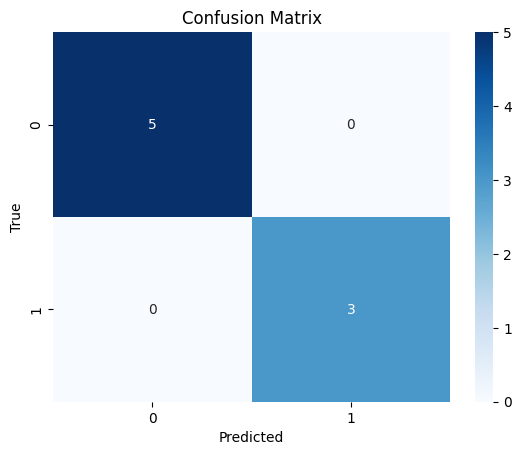

In [7]:
# Step 6: Evaluate the model using accuracy, precision, recall, F1-score, and confusion matrix.

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
print("🔥 ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


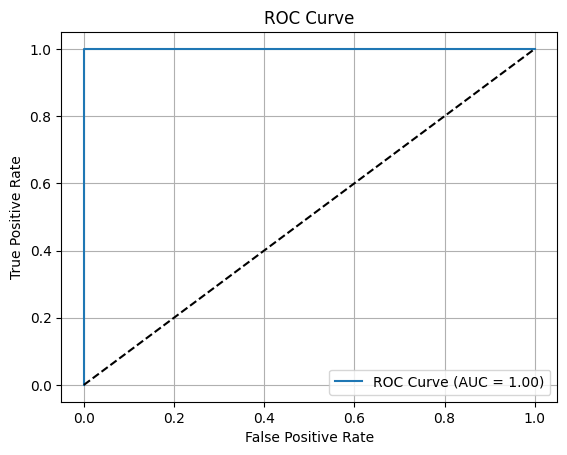

In [8]:
# Step 7: Plot the ROC curve to visualize model performance across different thresholds.

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


## 🔍 The below block is used to test a specific audio file individually.
**⬇️⬇️It checks whether the selected hive audio contains the Queen Bee or not. The model processes the selected audio, extracts MFCC features,and then predicts the queen bees presence (1) or absence (0).⬇️⬇️**


In [9]:

import os

audio_dir = '/kaggle/input/to-bee-or-no-to-bee/'  # ✅ define path again

sample_filename = 'Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00.wav'
sample_path = os.path.join(audio_dir, sample_filename)

# Extract features
sample_features = extract_mfcc(sample_path).reshape(1, -1)

# Predict
predicted_label = model.predict(sample_features)[0]
predicted_proba = model.predict_proba(sample_features)[0][1]

# Output
if predicted_label == 1:
    print(f"✅ Queen Bee is PRESENT in '{sample_filename}' (Confidence: {predicted_proba:.2f})")
else:
    print(f"❌ Queen Bee is NOT PRESENT in '{sample_filename}' (Confidence: {1 - predicted_proba:.2f})")


❌ Queen Bee is NOT PRESENT in 'Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00.wav' (Confidence: 0.92)
